## Download dataset

In [90]:
import pandas as pd
import numpy as np

import seaborn as sns
import warnings
from IPython.display import display, Markdown

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm
from boruta import boruta_py

import matplotlib.pyplot as plt

%matplotlib inline
%config IPCompleter.greedy=True
warnings.filterwarnings('ignore')

## Custom methods

In [91]:
# get the percentage of nulls on pandas dataframe
def val_pd_df_nan(df):
    flat_data = df.values.flatten()
    count=0
    for value in flat_data:
        if value is not None:
            continue
        count+= 1
    return round(100*count/len(flat_data))


## Load data
The training set contains 60000 examples in total in which 59000 belong to the negative class and 1000 positive class. The test set contains 16000 examples. There are 171 attributes per record.

The attribute names of the data have been anonymized for proprietary reasons. It consists of both single numerical counters and histograms consisting of bins with different conditions. Typically the histograms have open-ended conditions at each end. For example, if we measuring the ambient temperature "T" then the histogram could be defined with 4 bins where:

The attributes are as follows: class, then anonymized operational data. The operational data have an identifier and a bin id, like "Identifier_Bin". In total there are 171 attributes, of which 7 are histogram variables. Missing values are denoted by "na".

In [92]:
train_ds = pd.read_csv('data/aps_failure_training_set_processed_8bit.csv', na_values='na')
test_ds =  pd.read_csv('data/aps_failure_test_set_processed_8bit.csv', na_values='na')

train_labels = train_ds['class']
test_labels = test_ds['class']
train_features = train_ds.drop('class', axis=1)
test_features = test_ds.drop('class', axis=1)

print(train_labels.shape, test_labels.shape)
print(train_features.shape, test_features.shape)

(60000,) (16000,)
(60000, 170) (16000, 170)


In [93]:
train_ds

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.992188,0.117188,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.687500,0.515625,0.234375,0.070312,0.007812,-0.109375,-0.140625,-0.171875,-0.023438,-0.023438
1,-0.992188,-0.179688,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.023438,-0.062500,-0.132812,-0.132812,-0.187500,-0.148438,-0.085938,-0.140625,-0.023438,-0.023438
2,-0.992188,-0.125000,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.140625,-0.093750,-0.015625,0.015625,-0.007812,-0.109375,-0.093750,-0.164062,-0.023438,-0.023438
3,-0.992188,-0.406250,-0.289062,-0.468750,-0.007812,-0.046875,-0.007812,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,0.890625,0.992188
4,-0.992188,0.007812,-0.289062,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.156250,0.031250,-0.031250,-0.039062,-0.046875,-0.015625,0.656250,-0.148438,-0.023438,-0.023438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.992188,0.640625,0.007812,-0.468750,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.476562,0.656250,0.718750,0.734375,0.640625,0.218750,0.992188,0.421875,-0.023438,-0.023438
59996,-0.992188,-0.390625,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.375000,-0.375000,-0.359375,-0.289062,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
59997,-0.992188,-0.406250,-0.289062,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,-0.382812,-0.382812,-0.375000,-0.351562,-0.312500,-0.195312,-0.304688,-0.171875,-0.023438,-0.023438
59998,-0.992188,0.140625,0.304688,0.992188,-0.007812,-0.046875,-0.054688,-0.007812,-0.03125,-0.054688,...,0.218750,0.023438,-0.085938,-0.148438,-0.132812,-0.101562,0.992188,0.992188,-0.023438,-0.023438


In [94]:
print(f'{val_pd_df_nan(train_features)}% of train data are non-valid.')
print(f'{val_pd_df_nan(test_features)}% of test data are non-valid.')

0% of train data are non-valid.
0% of test data are non-valid.


In [96]:
# train_features.describe()

In [97]:
scaler = MinMaxScaler()
scaler.fit(train_features)

train_features = pd.DataFrame(scaler.transform(train_features), columns=train_features.columns)
test_features = pd.DataFrame(scaler.transform(test_features), columns=test_features.columns)

In [98]:
# train_features.describe()

In [99]:
train_labels = train_labels.apply(round)
train_labels = train_labels.replace({-1:0})

test_labels = test_labels.apply(round)
test_labels = test_labels.replace({-1:0})

In [102]:
print(train_labels.value_counts())
print(test_labels.value_counts())

0    59000
1     1000
Name: class, dtype: int64
0    15625
1      375
Name: class, dtype: int64


## Sampling

In [121]:
number_samples = 1000

idxs_pos = train_labels[train_labels==1].index
idxs_neg = train_labels[train_labels==0].sample(n=number_samples, replace=False, random_state=0).index
idxs_balanced = np.concatenate((idxs_pos,idxs_neg))
train_features_balanced = train_features.loc[idxs_balanced]
train_labels_balanced = train_labels.loc[idxs_balanced]
print(f'Proportion balanced: {int(number_samples/1000)}/1')
print(train_labels_balanced.value_counts())

Proportion balanced: 1/1
1    1000
0    1000
Name: class, dtype: int64


In [126]:
number_samples = 375

idxs_pos = test_labels[test_labels==1].index
idxs_neg = test_labels[test_labels==0].sample(n=number_samples, replace=False, random_state=0).index
idxs_balanced = np.concatenate((idxs_pos,idxs_neg))
test_features_balanced = test_features.loc[idxs_balanced]
test_labels_balanced = test_labels.loc[idxs_balanced]
print(f'Proportion balanced: {int(number_samples/1000)}/1')
print(test_labels_balanced.value_counts())

Proportion balanced: 0/1
1    375
0    375
Name: class, dtype: int64


## Correlation Heatmap

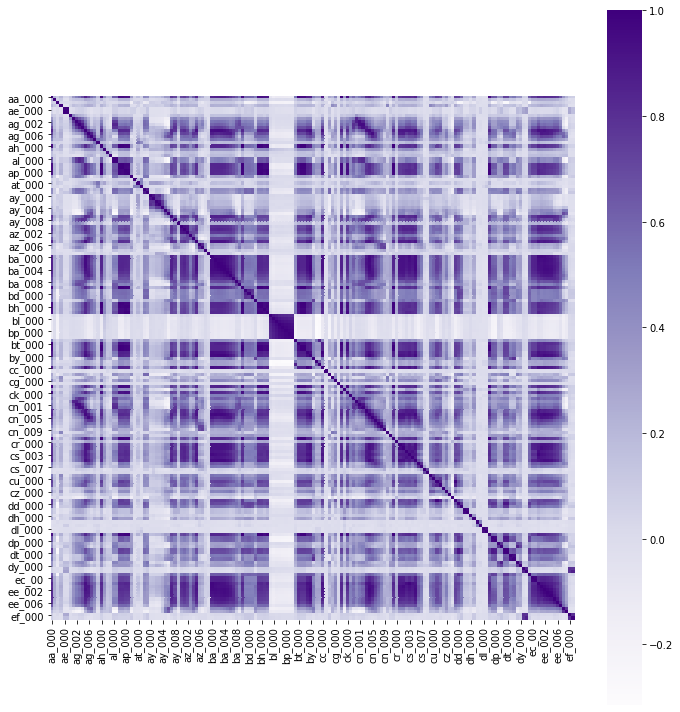

In [150]:
fig, ax = plt.subplots(figsize=(10,10))
corr_matrix = train_features_balanced.corr()
ax = sns.heatmap(corr_matrix, square=True, cmap='Purples', ax=ax)
plt.tight_layout()
plt.show()

## Select KBest

In [78]:
# k_best = 84
# selectKBest = SelectKBest(chi2, k_best)
# selectKBest.fit(train_features, train_labels)
# best_train_features = selectKBest.transform(train_features)

# idxs_selected = selectKBest.get_support(indices=True)
# best_train_features = train_features.iloc[:,idxs_selected]

# print(best_train_features.columns)

In [79]:
# fig, ax = plt.subplots(figsize=(10,10))
# new_corr_matrix = best_train_features.corr()
# ax = sns.heatmap(new_corr_matrix, square=True, cmap='Purples', ax=ax)
# plt.tight_layout()
# plt.show()

In [80]:
# pca_variance = 0.95 

# pca = PCA(pca_variance)
# pca.fit(train_features)
# best_train_features = pca.transform(train_features)
# best_train_features = pd.DataFrame(best_train_features)

# print(f'Number of components {pca.n_components_}')

## Feature selection with Boruta

In [82]:
# from boruta import boruta_py

# # define random forest classifier, with utilising all cores and
# # sampling in proportion to y labels
# forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# # define Boruta feature selection method
# feat_selector = boruta_py.BorutaPy(forest, n_estimators='auto', verbose=2, random_state=123)

# # find all relevant features
# feat_selector.fit(train_features.values, train_labels.values)

# # check selected features
# print(feat_selector.support_)

# # check ranking of features
# print(feat_selector.ranking_)

# # # call transform() on X to filter it down to selected features
# # X_filtered = feat_selector.transform(X)

In [83]:
# result
# [ True False False False False False False  True  True  True  True  True
#   True  True  True False  True  True False False  True  True  True  True
#   True  True  True False False False  True False  True  True  True  True
#  False False  True  True  True  True  True  True  True  True  True  True
#  False False False False  True  True  True  True  True  True  True  True
#   True  True  True  True  True  True False  True  True  True  True  True
#   True  True  True  True  True  True  True  True  True  True  True  True
#   True False False False  True False False False  True False  True  True
#   True  True  True  True  True  True  True  True  True  True  True  True
#   True False False  True False  True  True  True  True  True  True  True
#   True  True False False  True  True  True False False False False  True
#   True  True  True  True False  True False False False False  True  True
#  False  True  True  True  True False  True  True False False False  True
#   True  True  True  True  True  True  True  True  True  True  True False
#  False False]
# [ 1 20 22 42 21 23 28  1  1  1  1  1  1  1  1 13  1  1  7 30  1  1  1  1
#   1  1  1 43 25 27  1  3  1  1  1  1  3  2  1  1  1  1  1  1  1  1  1  1
#   5  3 24 31  1  1  1  1  1  1  1  1  1  1  1  1  1  1 11  1  1  1  1  1
#   1  1  1  1  1  1  1  1  1  1  1  1  1 11 15 16  1 19  2 36  1 44  1  1
#   1  1  1  1  1  1  1  1  1  1  1  1  1 34  8  1 11  1  1  1  1  1  1  1
#   1  1 39  5  1  1  1 17  9 25 14  1  1  1  1  1 17  1 37 29 41 39  1  1
#   2  1  1  1  1  2  1  1  2 35 32  1  1  1  1  1  1  1  1  1  1  1  1  2
#  38 32]

In [185]:
selectKBest = SelectKBest(chi2, 88)

pca = PCA(0.95)

borutaSelector = boruta_py.BorutaPy(
    RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5), 
    n_estimators='auto', 
    verbose=0, 
    random_state=123
)

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

In [186]:
from sklearn.pipeline import Pipeline

# estimators pipeline
rf_pipeline = Pipeline([('rf', rf)])
kbest_pipeline = Pipeline([('selectKBest', selectKBest), ('rf', rf)])
pca_pipeline = Pipeline([('pca', pca), ('rf', rf)])
boruta_pipeline = Pipeline([('borutaSelector', borutaSelector), ('rf', rf)])


## KBest + RF

In [187]:
kbest_pipeline.fit(train_features_balanced, train_labels_balanced)

# train
y_pred = kbest_pipeline.predict(train_features_balanced)
report = classification_report(train_labels_balanced, y_pred)
print(report)

# test
y_pred = kbest_pipeline.predict(test_features_balanced)
report = classification_report(test_labels_balanced, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1000
           1       0.96      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       375
           1       0.94      0.98      0.96       375

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



In [188]:
print("columns count:", len(train_features_balanced.columns))
print("columns count after kbest:", len(train_features_balanced.columns[kbest_pipeline[0].get_support()]))
print("columns selected:", train_features_balanced.columns[kbest_pipeline[0].get_support()].values)

columns count: 170
columns count after kbest: 88
columns selected: ['aa_000' 'ag_001' 'ag_002' 'ag_003' 'ag_004' 'ag_005' 'ag_006' 'ah_000'
 'ai_000' 'al_000' 'am_0' 'an_000' 'ao_000' 'ap_000' 'aq_000' 'ay_007'
 'ay_008' 'az_000' 'az_001' 'az_002' 'az_004' 'az_005' 'ba_000' 'ba_001'
 'ba_002' 'ba_003' 'ba_004' 'ba_005' 'ba_006' 'ba_007' 'ba_008' 'ba_009'
 'bb_000' 'bc_000' 'bd_000' 'be_000' 'bf_000' 'bg_000' 'bh_000' 'bi_000'
 'bj_000' 'bt_000' 'bu_000' 'bv_000' 'bx_000' 'by_000' 'cc_000' 'ci_000'
 'cj_000' 'ck_000' 'cl_000' 'cm_000' 'cn_000' 'cn_001' 'cn_002' 'cn_003'
 'cn_004' 'cn_005' 'cn_006' 'cn_007' 'cn_008' 'cq_000' 'cs_000' 'cs_001'
 'cs_002' 'cs_003' 'cs_004' 'cs_005' 'cu_000' 'cv_000' 'cx_000' 'dc_000'
 'dd_000' 'de_000' 'dn_000' 'ds_000' 'dt_000' 'eb_000' 'ec_00' 'ed_000'
 'ee_000' 'ee_001' 'ee_002' 'ee_003' 'ee_004' 'ee_005' 'ee_006' 'ee_007']


## PCA + RF

In [147]:
pca_pipeline.fit(train_features_balanced, train_labels_balanced)

# train
y_pred = pca_pipeline.predict(train_features_balanced)
report = classification_report(train_labels_balanced, y_pred)
print(report)

# test
y_pred = pca_pipeline.predict(test_features_balanced)
report = classification_report(test_labels_balanced, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      1000
           1       0.94      0.97      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       375
           1       0.91      0.99      0.95       375

    accuracy                           0.94       750
   macro avg       0.95      0.94      0.94       750
weighted avg       0.95      0.94      0.94       750



In [177]:
print("columns count:", len(train_features_balanced.columns))
print("pca components:", pca_pipeline[0].n_components_)

columns count: 170
pca components: 48


## Boruta + RF

In [146]:
boruta_pipeline.fit(train_features_balanced.values, train_labels_balanced.values)

# train
y_pred = boruta_pipeline.predict(train_features_balanced.values)
report = classification_report(train_labels_balanced, y_pred)
print(report)

# test
y_pred = boruta_pipeline.predict(test_features_balanced.values)
report = classification_report(test_labels_balanced, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1000
           1       0.96      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

              precision    recall  f1-score   support

           0       0.98      0.93      0.96       375
           1       0.94      0.98      0.96       375

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



In [176]:
print("columns count:", len(train_features_balanced.columns))
print("columns count after boruta:", len(train_features_balanced.columns[boruta_pipeline[0].support_]))
print("columns selected:", train_features_balanced.columns[boruta_pipeline[0].support_].values)

columns count: 170
columns count after boruta: 88
columns selected: ['aa_000' 'ag_001' 'ag_002' 'ag_003' 'ag_004' 'ag_005' 'ag_006' 'ah_000'
 'ai_000' 'al_000' 'am_0' 'an_000' 'ao_000' 'ap_000' 'aq_000' 'ay_006'
 'ay_008' 'az_000' 'az_001' 'az_002' 'az_005' 'ba_000' 'ba_001' 'ba_002'
 'ba_003' 'ba_004' 'ba_005' 'ba_008' 'ba_009' 'bb_000' 'bc_000' 'bd_000'
 'be_000' 'bg_000' 'bh_000' 'bi_000' 'bj_000' 'bk_000' 'bl_000' 'bm_000'
 'bn_000' 'bp_000' 'bq_000' 'br_000' 'bs_000' 'bt_000' 'bu_000' 'bv_000'
 'bx_000' 'by_000' 'cc_000' 'cg_000' 'ci_000' 'cj_000' 'ck_000' 'cl_000'
 'cm_000' 'cn_000' 'cn_001' 'cn_002' 'cn_003' 'cn_004' 'cn_007' 'cn_008'
 'cn_009' 'cq_000' 'cs_001' 'cs_002' 'cs_003' 'cs_004' 'cs_005' 'cx_000'
 'dc_000' 'dd_000' 'de_000' 'dn_000' 'dq_000' 'ds_000' 'dt_000' 'ec_00'
 'ed_000' 'ee_000' 'ee_001' 'ee_002' 'ee_004' 'ee_005' 'ee_006' 'ee_007']


## RF only

In [145]:
rf_pipeline.fit(train_features_balanced, train_labels_balanced)

# train
y_pred = rf_pipeline.predict(train_features_balanced)
report = classification_report(train_labels_balanced, y_pred)
print(report)

# test
y_pred = rf_pipeline.predict(test_features_balanced)
report = classification_report(test_labels_balanced, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1000
           1       0.96      0.97      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       375
           1       0.93      0.98      0.95       375

    accuracy                           0.95       750
   macro avg       0.95      0.95      0.95       750
weighted avg       0.95      0.95      0.95       750

